'training_loss_math.png'

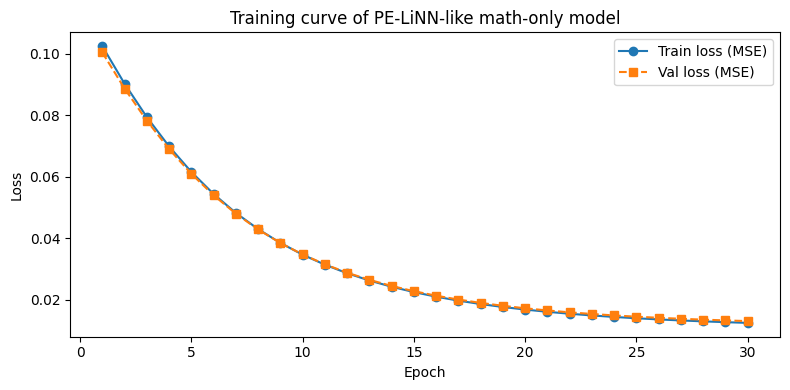

In [1]:
# Synthetic PE-LiNN-like training by math (no Qiskit). 
# We learn a quasi-inverse mapping from noisy expectation values u in [-1,1] 
# to clean targets y in [-1,1] with a single "liquid" neuron derived from Hasani et al.'s LTC update.
# The loss curve is saved to training_loss_math.png

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# ---- 1) Generate a synthetic dataset ----
# Clean expectations y from a simple analytic circuit family: y = cos(theta)
N = 2000
theta = rng.uniform(0, 2*np.pi, size=N)
y_clean = np.cos(theta)

# Noise model (affine shrink + bias + shot noise), mimicking amplitude damping bias toward +1 on Z
alpha = 0.82     # contraction from depolarizing-like effects
beta  = 0.06     # bias term from amplitude damping
sigma = 0.02     # shot/readout noise
u_noisy = alpha*y_clean + beta + rng.normal(0, sigma, size=N)
u_noisy = np.clip(u_noisy, -1.0, 1.0)

# Train/val split
idx = rng.permutation(N)
train_idx = idx[:1600]
val_idx   = idx[1600:]

u_tr, y_tr = u_noisy[train_idx], y_clean[train_idx]
u_va, y_va = u_noisy[val_idx],   y_clean[val_idx]

# ---- 2) Define a tiny "liquid" neuron (single-step LTC) ----
# x1 = (x0 + dt * g * A) / (1 + dt * (1/tau + g))
# g = tanh(wr*x0 + w*u + b); use x0 = u to keep liquid dynamics input-coupled
# readout: y_hat = tanh(v*x1 + c) to keep outputs within [-1,1] (physical observable range)

def forward(u, params):
    w, wr, b, A, tau, v, c = params
    x0 = u
    h = wr*x0 + w*u + b
    g = np.tanh(h)
    dt = 1.0  # fixed step
    num = x0 + dt * g * A
    den = 1.0 + dt * (1.0/tau + g)
    x1 = num / den
    y_hat = np.tanh(v*x1 + c)
    cache = (u, x0, h, g, num, den, x1, y_hat)
    return y_hat, cache

def mse(y_hat, y):
    return np.mean((y_hat - y)**2)

# ---- 3) Analytic gradients for simple SGD (no autograd) ----
def gradients(u, y, params):
    w, wr, b, A, tau, v, c = params
    y_hat, cache = forward(u, params)
    (u_in, x0, h, g, num, den, x1, yhat) = cache
    
    # derivatives of loss wrt y_hat
    dL_dyhat = 2.0*(yhat - y)/y.size
    
    # y_hat = tanh(v*x1 + c)
    dz = v*x1 + c
    dyhat_dz = 1.0 - np.tanh(dz)**2
    dL_dz = dL_dyhat * dyhat_dz
    
    # gradients wrt v and c
    dL_dv = np.sum(dL_dz * x1)
    dL_dc = np.sum(dL_dz * 1.0)
    
    # x1 = num / den
    dL_dx1 = dL_dz * v
    
    # common pieces
    dt = 1.0
    # g derivatives
    sech2 = 1.0 - np.tanh(h)**2  # equals 1 - g^2
    dg_dw  = sech2 * u_in
    dg_dwr = sech2 * x0
    dg_db  = sech2 * 1.0
    
    # num = x0 + dt*g*A
    dnum_dg = dt * A
    dnum_dA = dt * g
    
    # den = 1 + dt*(1/tau + g)
    dden_dg   = dt * 1.0
    dden_dtau = dt * (-1.0 / (tau**2))
    
    # x1 = num / den -> use quotient rule element-wise
    dx1_dg   = (dnum_dg*den - num*dden_dg) / (den**2)
    dx1_dA   = (dnum_dA*den - num*0.0)    / (den**2)
    dx1_dtau = (0.0*den - num*dden_dtau)  / (den**2)  # since num doesn't depend on tau
    
    # chain to parameters
    dL_dg   = np.sum(dL_dx1 * dx1_dg)
    dL_dA   = np.sum(dL_dx1 * dx1_dA)
    dL_dtau = np.sum(dL_dx1 * dx1_dtau)
    
    dL_dw  = np.sum(dL_dx1 * dx1_dg * dg_dw)
    dL_dwr = np.sum(dL_dx1 * dx1_dg * dg_dwr)
    dL_db  = np.sum(dL_dx1 * dx1_dg * dg_db)
    
    # pack
    grads = np.array([dL_dw, dL_dwr, dL_db, dL_dA, dL_dtau, dL_dv, dL_dc], dtype=float)
    return grads, yhat

# ---- 4) Train with SGD ----
# Initialize parameters near zero; keep tau positive via softplus on an internal parameter if needed.
# Here we directly constrain tau > 0 by projecting after each update.
params = np.array([0.2, 0.1, 0.0, 0.5, 1.5, 1.0, 0.0], dtype=float)  # [w, wr, b, A, tau, v, c]

lr = 0.02
epochs = 30
batch_size = 200

loss_tr_hist = []
loss_va_hist = []

for ep in range(epochs):
    # mini-batch SGD
    perm = rng.permutation(u_tr.size)
    for i in range(0, u_tr.size, batch_size):
        idx = perm[i:i+batch_size]
        grads, _ = gradients(u_tr[idx], y_tr[idx], params)
        params -= lr * grads
        # enforce tau>0 softly
        if params[4] <= 0.05:
            params[4] = 0.05
    
    # logging
    yhat_tr, _ = forward(u_tr, params)
    yhat_va, _ = forward(u_va, params)
    loss_tr_hist.append(mse(yhat_tr, y_tr))
    loss_va_hist.append(mse(yhat_va, y_va))

# ---- 5) Plot loss curve ----
plt.figure(figsize=(8,4))
plt.plot(range(1, epochs+1), loss_tr_hist, marker='o', label='Train loss (MSE)')
plt.plot(range(1, epochs+1), loss_va_hist, marker='s', linestyle='--', label='Val loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training curve of PE-LiNN-like math-only model')
plt.legend()
plt.tight_layout()
out_path = 'training_loss_math.png'
plt.savefig(out_path, dpi=150)
out_path


Validation MAE (raw noisy): 0.117
Validation MAE (PE-LiNN mitigated): 0.087


'math_mae_comparison.png'

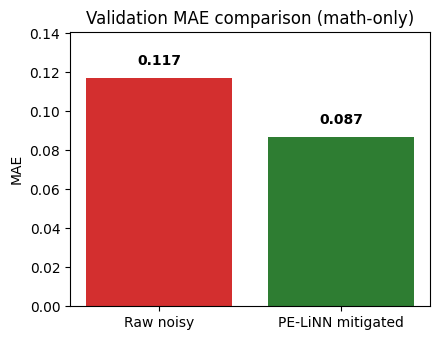

In [3]:
# Quantify the mitigation on the validation set and visualize MAE improvement
mae_noisy = np.mean(np.abs(u_va - y_va))
yhat_va_final, _ = forward(u_va, params)
mae_mitigated = np.mean(np.abs(yhat_va_final - y_va))

print(f"Validation MAE (raw noisy): {mae_noisy:.3f}")
print(f"Validation MAE (PE-LiNN mitigated): {mae_mitigated:.3f}")

plt.figure(figsize=(4.5, 3.5))
bars = plt.bar(['Raw noisy', 'PE-LiNN mitigated'], [mae_noisy, mae_mitigated], color=['#D32F2F', '#2E7D32'])
for rect, value in zip(bars, [mae_noisy, mae_mitigated]):
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.005, f"{value:.3f}",
             ha='center', va='bottom', fontweight='bold')
plt.ylabel('MAE')
plt.title('Validation MAE comparison (math-only)')
plt.ylim(0, max(mae_noisy, mae_mitigated) * 1.2)
plt.tight_layout()
out_path = 'math_mae_comparison.png'
plt.savefig(out_path, dpi=150)
out_path


In [4]:
y_clean

array([ 0.14995256, -0.92715926,  0.63061148, ..., -0.50929492,
        0.56571251, -0.99205797])